# HW: Sequence Data
---

### data
```
    CCTS40500/problems/hwdata/hiv/*seq
```

In [0]:
import pandas as pd
import numpy as np 

# Problem:
---

+ Classify LTNP, RP, P, SP
+ Explore Random forests, Decision trees, Extra-trees, Gardient Boosting, LGBM
+ Plot the ROC curves for all pairs, and note the best AUCS
+ First sensitivity at 95% specificity
+ Compute PPV
+ Report Best PPV, and the classifier that achieves that
+ rint the confusion matrix

In [0]:
from google.colab import files
import io

uploaded = files.upload()

ltnp_df = pd.read_csv(io.BytesIO(uploaded['hiv-db-LTNP.seq']), header=None)
sp_df = pd.read_csv(io.BytesIO(uploaded['hiv-db-SP.seq']), header=None)
zp_df = pd.read_csv(io.BytesIO(uploaded['hiv-db-zP.seq']), header=None)
zrp_df = pd.read_csv(io.BytesIO(uploaded['hiv-db-zRP.seq']), header=None)



Saving hiv-db-LTNP.seq to hiv-db-LTNP.seq
Saving hiv-db-SP.seq to hiv-db-SP.seq
Saving hiv-db-zP.seq to hiv-db-zP.seq
Saving hiv-db-zRP.seq to hiv-db-zRP.seq


In [0]:
# Find max length of sequence

dfs = [ltnp_df, sp_df, zp_df, zrp_df]
lens = []

for item in dfs:
    lens.append(max([len(row) for row in item[0]]))

seq_len = max(lens)
print(seq_len)

9840


In [0]:
# Perform preproc and concat dataframes
codon_map = {"A": 1, "C": 2, "T": 3, "G": 4}
def splitw(word): 
    return np.array([codon_map[char] for char in word]).astype(int)

labels = [1, 2, 3, 4]
proced_dfs = []

# Replace letters iwth numbers, and create label col
for i, df in enumerate(dfs):
    new_ser = df[0].apply(splitw)
    new_df = new_ser.apply(pd.Series)
    new_df["label"] = i
    proced_dfs.append(new_df)

df = pd.concat(proced_dfs)
df.fillna(0, axis=1, inplace=True)
df


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9801,9802,9803,9804,9805,9806,9807,9808,9809,9810,9811,9812,9813,9814,9815,9816,9817,9818,9819,9820,9821,9822,9823,9824,9825,9826,9827,9828,9829,9830,9831,9832,9833,9834,9835,9836,9837,9838,9839,label
0,1.0,1.0,4.0,2.0,4.0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,1.0,4.0,4.0,1.0,4.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,4.0,1.0,2.0,4.0,2.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2.0,2.0,2.0,4.0,1.0,1.0,2.0,1.0,4.0,4.0,4.0,1.0,2.0,3.0,3.0,4.0,1.0,1.0,1.0,4.0,2.0,4.0,1.0,1.0,1.0,4.0,1.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,1.0,4.0,4.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,1.0,1.0,2.0,2.0,1.0,4.0,1.0,4.0,4.0,1.0,4.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,4.0,1.0,2.0,4.0,2.0,1.0,4.0,4.0,1.0,2.0,3.0,2.0,4.0,4.0,2.0,3.0,3.0,4.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.0,2.0,1.0,4.0,4.0,4.0,1.0,2.0,3.0,3.0,4.0,1.0,1.0,1.0,4.0,2.0,4.0,1.0,1.0,1.0,4.0,4.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,1.0,4.0,1.0,1.0,4.0,1.0,3.0,2.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,3.0,4.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,1.0,4.0,2.0,3.0,4.0,4.0,4.0,4.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,4.0,1.0,1.0,2.0,4.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,2.0,3.0,4.0,4.0,3.0,1.0,4.0,2.0,3.0,1.0,4.0,1.0,4.0,1.0,3.0,2.0,2.0,2.0,3.0,3.0,1.0,4.0,1.0,3.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,3.0,2.0,1.0,4.0,1.0,4.0,3.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
34,2.0,3.0,4.0,4.0,3.0,1.0,1.0,2.0,3.0,1.0,4.0,1.0,4.0,1.0,3.0,2.0,2.0,2.0,3.0,2.0,1.0,4.0,1.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0,3.0,2.0,1.0,4.0,1.0,4.0,3.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
35,2.0,3.0,4.0,4.0,3.0,1.0,4.0,2.0,3.0,1.0,4.0,1.0,4.0,1.0,3.0,2.0,2.0,2.0,3.0,3.0,1.0,4.0,1.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0,3.0,2.0,1.0,4.0,1.0,4.0,3.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
36,2.0,3.0,4.0,4.0,3.0,1.0,4.0,2.0,3.0,1.0,4.0,1.0,4.0,1.0,3.0,2.0,2.0,2.0,3.0,3.0,1.0,4.0,1.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0,3.0,2.0,1.0,4.0,1.0,4.0,3.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [0]:
# Training / test split
# Question: should i force the split ratio to be equal in each category (split
# each different strain before concat) or should I split the whole dataset
# once (split after concat)? Here I have split once after concat.

mask = np.random.rand(len(df)) < 0.67
train_df = df[mask]
test_df = df[~mask]

# From this, we can see that the ratio of each strain in test/train can be
# very far from the intented ratio if we split after we concat.
print(train_df["label"].value_counts() / df["label"].value_counts())
print(test_df["label"].value_counts() / df["label"].value_counts())

0    0.683333
3    0.763158
1    0.621622
2    0.782609
Name: label, dtype: float64
0    0.316667
1    0.378378
2    0.217391
3    0.236842
Name: label, dtype: float64


[0.4920981430849851, 0.4628835345940609, 0.4570071010860485, 0.4593206501101238, 0.47996126680337214]


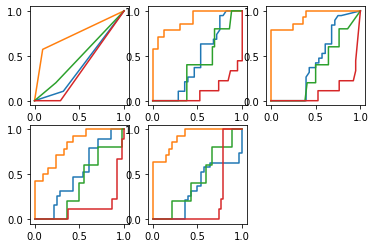

In [0]:
import itertools

import lightgbm
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import metrics
from sklearn import tree

%matplotlib inline

classifiers = [tree.DecisionTreeClassifier(max_depth=None,
                                               min_samples_split=2, 
                                               random_state=0),
               ensemble.RandomForestClassifier(n_estimators=500, max_depth=None,
                                   min_samples_split=2, random_state=0),
               ensemble.ExtraTreesClassifier(n_estimators=500, max_depth=None,
                                 min_samples_split=2, random_state=0),
               lightgbm.LGBMClassifier(),
               ensemble.GradientBoostingClassifier(
                   n_estimators=100,max_depth=4)
               ]

fitted = []
fpr_l = []
tpr_l = []
classes = [0, 1, 2, 3]
aucs_avg = []
clfs = ["Dec Tree", "rand forest", "extra tree", "lgbm", "grad boost"]

for i, clf in enumerate(classifiers):
    plt.subplot(2, 3, i+1)
    clf.fit(train_df.loc[:, range(0, seq_len)], train_df.loc[:, "label"])
    fitted.append(clf)

    aucs = []
    # For each strain, get classification metrics and plot
    for strain in classes:
        y_pred = clf.predict_proba(test_df.loc[:, range(0, seq_len)])

        fpr, tpr, thresholds = metrics.roc_curve(test_df["label"], y_pred[:,1],
                                                 pos_label=strain)
        auc = metrics.auc(fpr, tpr)
        aucs.append(auc)
        plt.plot(fpr, tpr)

    aucs_avg.append(sum(aucs) / len(aucs))

print(aucs_avg)  # Random forest and extra trees works the best

In [0]:
# Sensitivity at 95% specificity


array([1.99943197e+00, 9.99431972e-01, 2.36478241e-04, 1.89607206e-04,
       1.66466679e-04, 1.60278311e-04, 1.49442203e-04, 1.47741114e-04,
       1.31314395e-04, 1.31253052e-04, 1.25129832e-04, 1.17234358e-04,
       1.08354537e-04, 7.53725576e-05])

In [0]:
# Confusion matricies and ppv
ppvs = []
for i, clf in enumerate(fitted):
    y_pred = clf.predict(test_df.loc[:, range(0, seq_len)])
    conf = metrics.confusion_matrix(test_df["label"], y_pred, labels=classes)
    ppv = metrics.precision_score(test_df["label"], y_pred, average="micro")
    print(clfs[i], "\n", "PPV: {} \n".format(ppv), conf, "\n")

    ppvs.append(ppv)

ppv_idx = np.argmax(ppvs)
print("The highest ppv was achieved by {}, with a value of {}".format(
    clfs[ppv_idx], max(ppvs)))

Dec Tree 
 PPV: 0.6808510638297872 
 [[14  2  1  2]
 [ 3  8  1  2]
 [ 2  1  1  1]
 [ 0  0  0  9]] 

rand forest 
 PPV: 0.7659574468085106 
 [[19  0  0  0]
 [ 6  7  1  0]
 [ 2  0  1  2]
 [ 0  0  0  9]] 

extra tree 
 PPV: 0.7872340425531915 
 [[19  0  0  0]
 [ 6  7  1  0]
 [ 1  0  2  2]
 [ 0  0  0  9]] 

lgbm 
 PPV: 0.6595744680851063 
 [[16  3  0  0]
 [ 6  6  2  0]
 [ 2  0  1  2]
 [ 1  0  0  8]] 

grad boost 
 PPV: 0.7659574468085106 
 [[17  0  0  2]
 [ 4  8  1  1]
 [ 3  0  2  0]
 [ 0  0  0  9]] 

The highest ppv was achieved by extra tree, with a value of 0.7872340425531915
